In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100
import japanize_matplotlib

from time import time
import seaborn as sns
import pandas_profiling as pdp
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
import gc

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'IPAPGothic'

In [2]:
train=pd.read_feather('../data/train_feat3.ftr')
test=pd.read_feather('../data/test_feat3.ftr')

In [3]:
drop_cols=['rent/S_mean', 'rent/S_max',
       'rent/S_min', 'rent/S_median', 'rent/S_std', 'rent_mean', 'rent_max',
       'rent_min', 'rent_median', 'rent_std']
train.drop(drop_cols,axis=1,inplace=True)
test.drop(drop_cols,axis=1,inplace=True)


In [7]:
Y_train=np.log(train['rent'])
X_train=train.drop(['id','rent'],axis=1)
X_test=test.drop(['id','rent','level_0','index'],axis=1)

In [8]:
params = {
    'max_bin' : 63,
    'n_estimators' : 10000,
    'learning_rate': 0.01,
    'min_data_in_leaf' : 50,
    'num_leaves' : 100,
    'sparse_threshold' : 1.0,
    'device' : 'cpu',
    'save_binary': True,
    'seed' : 42,
    'feature_fraction_seed': 42,
    'bagging_seed' : 42,
    'drop_seed' : 42,
    'data_random_seed' : 42,
    'objective' : 'regression',
    'boosting_type' : 'gbdt',
    'verbose' : 0,
    'metric' : 'RMSE',
    'is_unbalance' : True,
    'boost_from_average' : False,
}

In [9]:
def rmse(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

In [11]:
splits = 10
folds = KFold(n_splits=splits,shuffle=True)

categorical_features=list(X_train.columns[X_train.dtypes=='category'])

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

training_start_time = time()

cv={}
y_preds = np.zeros(X_test.shape[0])

for fold_n, (trn_idx, val_idx) in enumerate(folds.split(X_train,Y_train)):
    cv_fold_start_time = time()
    print ('** Training fold {}'.format(fold_n + 1))
    X_trn, X_val = X_train.iloc[trn_idx], X_train.iloc[val_idx]
    y_trn, y_val = Y_train[trn_idx], Y_train[val_idx]
    eval_set  = [(X_trn,y_trn), (X_val, y_val)]
    
    reg = lgb.LGBMRegressor(**params)
    reg.fit(X_trn, y_trn,
            eval_set=eval_set, 
            eval_metric="rmse",
            early_stopping_rounds=100,
            categorical_feature = categorical_features,
            verbose= 500)
    
    del X_trn, y_trn
    
    val_pred=reg.predict(X_val)
    feature_importances['fold_{}'.format(fold_n + 1)] = reg.feature_importances_
    
    y_preds+=np.exp(reg.predict(X_test))/splits
    del reg, X_val
    val_rmse=rmse(np.exp(y_val),np.exp(val_pred))
    print('RMSE accuracy: {}'.format(val_rmse))
    cv[fold_n+1]=val_rmse
    del val_pred,y_val,val_rmse

    gc.collect()
    
    cv_fold_end_time = time()
    print ('fold completed in {}s'.format(cv_fold_end_time - cv_fold_start_time))
cv=pd.DataFrame(cv,index=['cv',])
print('CV RMSE:{}'.format(cv.mean(axis=1)))

** Training fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.108575	valid_1's rmse: 0.120079
[1000]	training's rmse: 0.0539508	valid_1's rmse: 0.0837871
[1500]	training's rmse: 0.0422929	valid_1's rmse: 0.0818517
[2000]	training's rmse: 0.0348965	valid_1's rmse: 0.0810867
[2500]	training's rmse: 0.02979	valid_1's rmse: 0.0806642
[3000]	training's rmse: 0.0259011	valid_1's rmse: 0.0804139
[3500]	training's rmse: 0.0229047	valid_1's rmse: 0.0802071
[4000]	training's rmse: 0.0203735	valid_1's rmse: 0.0800546
[4500]	training's rmse: 0.0182282	valid_1's rmse: 0.0799347
[5000]	training's rmse: 0.0164448	valid_1's rmse: 0.0798499
[5500]	training's rmse: 0.0148991	valid_1's rmse: 0.0797792
[6000]	training's rmse: 0.0135729	valid_1's rmse: 0.0797125
[6500]	training's rmse: 0.0123918	valid_1's rmse: 0.0796729
Early stopping, best iteration is:
[6451]	training's rmse: 0.0125121	valid_1's rmse: 0.079671
RMSE accuracy: 16196.830924140404
fold completed 

[5500]	training's rmse: 0.0145716	valid_1's rmse: 0.0850208
[6000]	training's rmse: 0.0132698	valid_1's rmse: 0.0849541
[6500]	training's rmse: 0.012173	valid_1's rmse: 0.0848911
[7000]	training's rmse: 0.0112008	valid_1's rmse: 0.0848423
[7500]	training's rmse: 0.010357	valid_1's rmse: 0.084804
[8000]	training's rmse: 0.00957823	valid_1's rmse: 0.0847777
[8500]	training's rmse: 0.00882428	valid_1's rmse: 0.084749
[9000]	training's rmse: 0.00822044	valid_1's rmse: 0.0847147
Early stopping, best iteration is:
[8991]	training's rmse: 0.00823097	valid_1's rmse: 0.0847145
RMSE accuracy: 16309.253140105042
fold completed in 181.64677095413208s
** Training fold 10
Training until validation scores don't improve for 100 rounds.
[500]	training's rmse: 0.108475	valid_1's rmse: 0.121099
[1000]	training's rmse: 0.0537701	valid_1's rmse: 0.0871655
[1500]	training's rmse: 0.0421231	valid_1's rmse: 0.085472
[2000]	training's rmse: 0.0346643	valid_1's rmse: 0.0846143
[2500]	training's rmse: 0.0294726	

findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


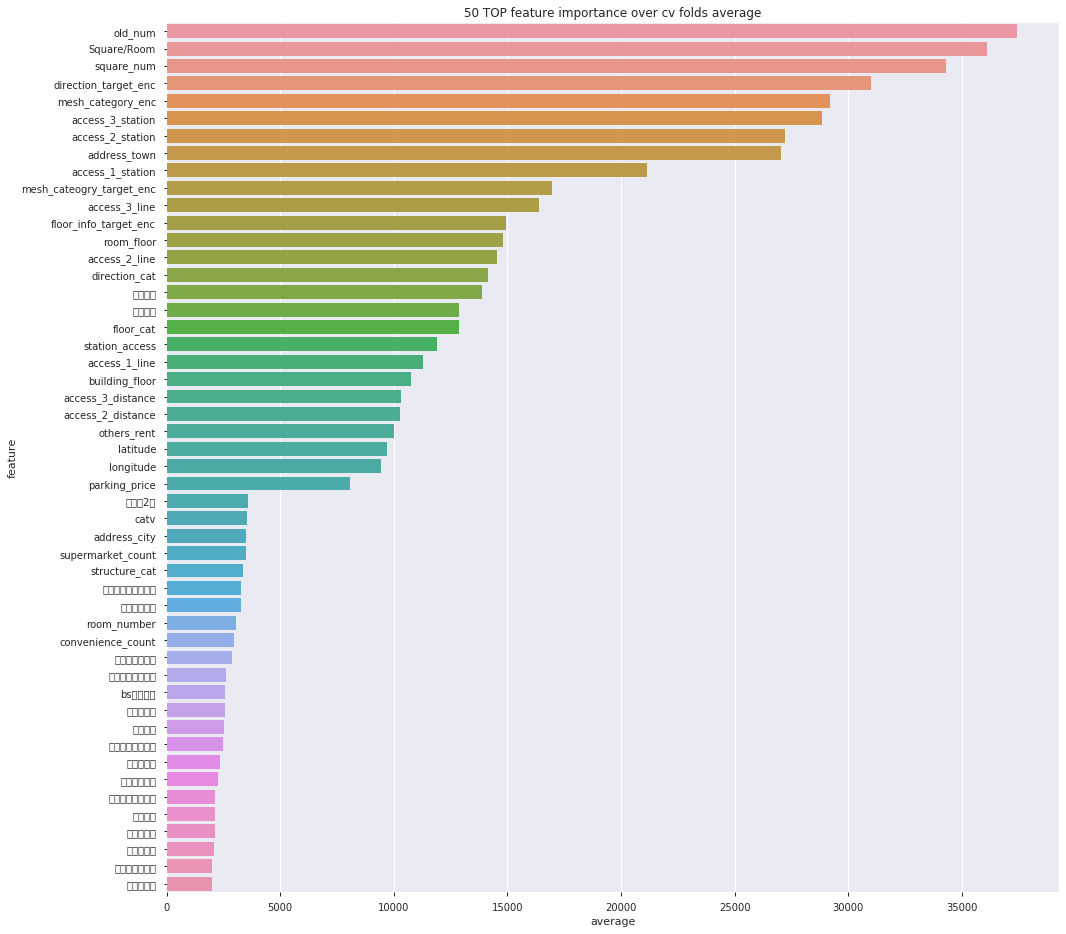

In [22]:
feature_importances['average'] = feature_importances.mean(axis=1)
feature_importances.to_feather('feat3_lighgbm_CV10_importance.ftr')
plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature')
plt.title('50 TOP feature importance over cv folds average');
plt.savefig('feat3_lighgbm_CV10_importance.png')

In [13]:
sub=pd.read_csv('../../../input/sample_submit.csv',header=None)
sub[1]=y_preds
sub.to_csv('feature3_lightgbm_CV10.csv',index=False,header=False)

In [20]:
print('CV mean:{:3f}'.format(cv.mean(axis=1)[0]))

CV mean:17219.508702


In [44]:
X_test

,R,K,DK,LDK,S,room_number,Square/Room,mesh_category_enc,floor_info_target_enc,direction_target_enc,mesh_cateogry_target_enc,others_rent,index,address_city,address_town,floor_cat,old_num,direction_cat,square_num,room_floor,building_floor,underground,シャワー,トイレなし,トイレ別,バスなし,共同トイレ,共同バス,専用トイレ,専用バス,洗面台独立,浴室乾燥機,温水洗浄便座,脱衣所,追焚機能,ihコンロ,l字キッチン,カウンターキッチン,ガスコンロ,コンロ1口,コンロ2口,コンロ3口,コンロ4口以上,コンロ設置可,システムキッチン,冷蔵庫あり,口数不明,独立キッチン,給湯,電気コンロ,...,床暖房,排水その他,敷地内ごみ置き場,水道その他,汲み取り,洗濯機置場なし,浄化槽,石油暖房,都市ガス,防音室,parking_price,convenience_count,supermarket_count,大学,郵便局,コインパーキング,ドラッグストア,銀行,スーパー,小学校,デパート,病院,コンビニ,幼稚園・保育園,総合病院,図書館,学校,クリーニング,月極駐車場,公園,レンタルビデオ,飲食店,structure_cat,is_rent,period_num,longitude,latitude,station_access,access_1_line,access_1_station,access_1_distance,access_2_line,access_2_station,access_2_distance,access_3_line,access_3_station,access_3_distance,access_4_line,access_4_station,access_4_distance
0,2,0,0,1,0,3.726175,13.477628,38,196236.268627,113782.776954,111722.222222,0.000000,31467,0,560,14,589,3,50.22,8,8,0,1,0,1,0,0,0,1,1,1,0,1,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,215,219,0,313,74,0,0,0,252,0,0,0,0,0,10,0,24,35.618929,139.648519,15,701,405,15,794,313,24,722,416,27,29,0,-999
1,1,0,0,0,0,1.000000,20.880000,172,82776.981503,131210.768238,154906.250000,176333.333333,31468,17,121,9,3,4,20.88,3,4,0,1,0,1,0,0,0,1,1,1,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,34000,2,2,0,0,0,0,0,313,0,0,0,374,0,0,0,0,0,0,0,0,0,3,0,24,35.618492,139.674894,6,722,490,6,722,416,17,701,416,17,29,0,-999
2,1,1,0,0,0,1.454488,18.515110,393,90514.389890,131210.768238,116946.902655,0.000000,31469,21,547,3,281,4,26.93,1,4,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,5000,2,2,0,0,0,0,0,810,0,0,0,371,0,0,0,0,0,0,0,0,0,10,0,24,35.740353,139.711786,10,834,105,10,372,307,16,404,337,19,29,0,-999
3,1,1,0,0,0,1.454488,16.205018,113,90514.389890,131210.768238,85000.000000,0.000000,31470,11,225,3,435,4,23.57,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,2,2,0,0,0,841,0,702,0,0,0,489,0,0,0,0,0,0,0,0,0,7,0,24,35.672791,139.660024,10,88,252,10,297,83,8,272,260,17,29,0,-999
4,2,0,0,1,0,3.726175,13.418586,50,196236.268627,113782.776954,88987.500000,0.000000,31471,11,239,14,545,3,50.00,4,4,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,1,0,22600,3,1,0,0,0,1166,1176,902,0,0,0,703,0,0,0,0,0,0,0,0,0,3,0,24,35.689924,139.647712,12,88,252,12,89,250,17,89,301,18,29,0,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31257,1,1,0,0,0,1.454488,17.641950,475,90514.389890,113991.111311,101216.417910,100833.333333,62724,21,25,3,2,6,25.66,6,8,0,1,0,1,0,0,0,1,1,1,1,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0,0,2,3,0,0,0,0,0,714,0,0,0,577,0,0,0,0,0,0,0,0,0,3,0,24,35.740681,139.720950,3,372,307,3,950,243,9,834,33,10,29,0,-999
31258,1,0,0,0,0,1.000000,22.710000,721,82776.981503,113782.776954,149358.585859,0.000000,62725,4,315,9,187,3,22.71,8,15,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0,43200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,24,35.693770,139.778852,2,1022,187,2,404,397,4,469,177,6,29,0,-999
31259,1,0,0,1,0,2.726175,16.785423,155,157748.328841,131210.768238,154168.141593,205868.421053,62726,2,540,5,13,4,45.76,10,14,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0,32400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,24,35.728242,139.664074,10,977,247,10,933,331,20,893,338,15,29,0,-999
31260,1,1,0,0,0,1.454488,37.951507,542,90514.389890,126057.842319,385307.692308,648000.000000,62727,4,84,3,185,